<a href="https://www.kaggle.com/code/samithsachidanandan/attention-is-all-you-need-implementation?scriptVersionId=248132595" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Understanding “Attention Is All You Need”

"Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wide variety of AI, such as large language models. At the time, the focus of the research was on improving Seq2seq techniques for machine translation, but the authors go further in the paper, foreseeing the technique's potential for other tasks like question answering and what is now known as multimodal generative AI.


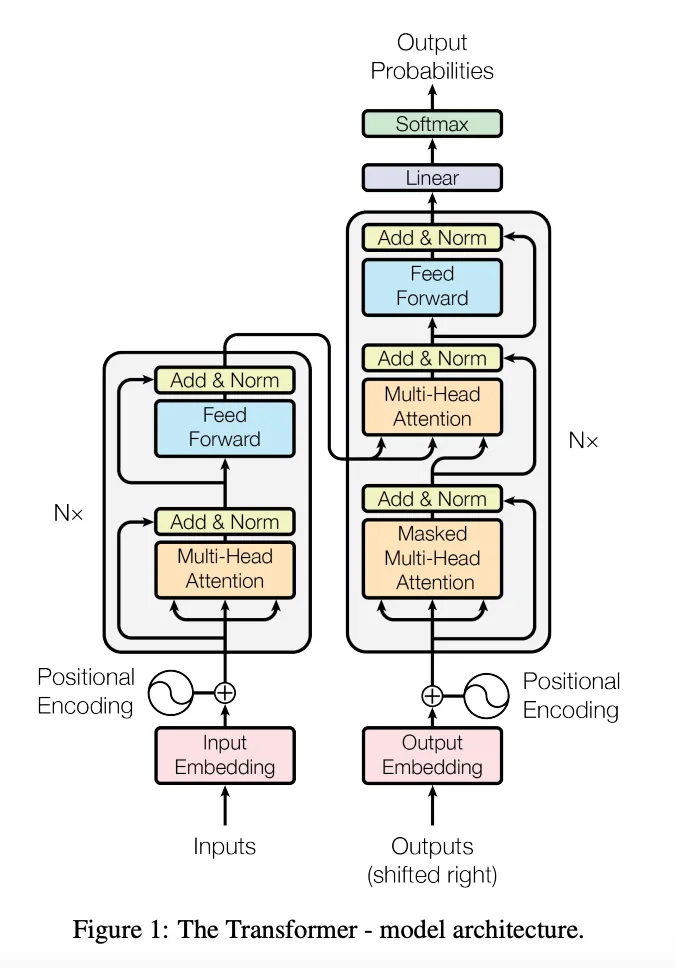

In [1]:
import torch 
import torch.nn as nn 

#### Multi-Head Self-Attention mechanism implementation.

This is the core component of the Transformer architecture that allows the model to attend to different positions in the input sequence.

In [2]:
class SelfAttention(nn.Module):
    
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size 
        self.heads = heads 
        self.head_dim = embed_size // heads 
        
        
        assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)

        
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        
        N =query.shape[0]

        
        value_len, key_len, query_len =  values.shape[1], keys.shape[1], query.shape[1]

        
        
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len,self.heads, self.head_dim )
        queries = query.reshape(N, query_len,self.heads, self.head_dim) 

           
        values = self.values(values)    
        keys = self.keys(keys)          
        queries = self.queries(queries) 
        

       
        
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        
        
        if mask is not None:
            energy = energy.masked_fill(mask ==0, float("-1e20"))

        
       
        attention = torch.softmax(energy / (self.embed_size **(1/2)), dim=3)

        
        out = torch.einsum("nhql,nlhd->nqhd",[attention, values]).reshape(N, query_len, self.heads*self.head_dim)
       

        
        out = self.fc_out(out)
        return out 


A single Transformer encoder block consisting of:

    1. Multi-head self-attention
    2. Feed-forward network
    
Both with residual connections and layer normalization

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        
        self.attention = SelfAttention(embed_size,heads)

       
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    
    def forward(self, value, key, query, mask):

        
        attention = self.attention(value, key, query, mask)

       
        x = self.dropout(self.norm1(attention + query))

       
        forward = self.feed_forward(x)

        
        out = self.dropout(self.norm2(forward + x ))
        return out 

Transformer Encoder consisting of:

    1. Input embeddings (word + positional)
    2. Stack of Transformer blocks

In [4]:
class Encoder(nn.Module):
    def __init__(
        self, 
        src_vocab_size,    
        embed_size,       
        num_layers,       
        heads,             
        device,           
        forward_expansion, 
        dropout,           
        max_length,        
    ):
        super(Encoder,self).__init__()
        self.embed_size = embed_size
        self.device = device

        
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)

        
        self.position_embedding = nn.Embedding(max_length, embed_size)

        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                    
                )
                               
            for _ in range(num_layers)        ]
            
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        
        
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

        
        out = self.dropout(
            self.word_embedding(x) + self.position_embedding(positions)
        )

        
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out 
        

A single Transformer decoder block consisting of:

    1. Masked self-attention (on target sequence)
    2. Cross-attention (attending to encoder output)
    3. Feed-forward network

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        
        
        self.attention = SelfAttention(embed_size, heads)
        
        
        self.norm = nn.LayerNorm(embed_size)
        
        
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        
        attention = self.attention(x, x, x, trg_mask)
        
        
        query = self.dropout(self.norm(attention + x))
        
        
        out = self.transformer_block(value, key, query, src_mask)
        
        return out
        

Transformer Decoder consisting of:

    1. Target embeddings (word + positional)
    2. Stack of Decoder blocks
    3. Output projection to vocabulary

In [6]:
class Decoder(nn.Module):
    
    def __init__(self,
                 trg_vocab_size,    
                 embed_size,        
                 num_layers,        
                 heads,             
                 forward_expansion, 
                 dropout,           
                 device,            
                 max_length):       
        super(Decoder, self).__init__()
        self.device = device

        
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        
        
        self.position_embedding = nn.Embedding(max_length, embed_size)

        
        self.layers = nn.ModuleList([
            DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)
        ])

        
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        
        
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

       
        x = self.dropout(
            self.word_embedding(x) + self.position_embedding(positions)
        )

       
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        
        out = self.fc_out(x)
        return out


Complete Transformer model for sequence-to-sequence tasks.
    
    Architecture:
    Input -> Encoder -> Decoder -> Output
    
    The encoder processes the source sequence and the decoder generates
    the target sequence while attending to the encoder output.

In [7]:
class Transformer(nn.Module):
    def __init__(
        self, 
        src_vocab_size,     
        trg_vocab_size,     
        src_pad_idx,        
        trg_pad_idx,        
        embed_size=256,     
        num_layers=6,       
        forward_expansion=4, 
        heads=8,           
        dropout=0,          
        device="cpu",      
        max_length=100      
    ):
        super(Transformer, self).__init__()
        
        
        self.encoder = Encoder(
            src_vocab_size,
            embed_size, 
            num_layers,
            heads, 
            device,
            forward_expansion,
            dropout,
            max_length
        )

      
        self.decoder = Decoder(
            trg_vocab_size,
            embed_size, 
            num_layers,
            heads, 
            forward_expansion,
            dropout,
            device,
            max_length
        )

        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device 

    def make_src_mask(self, src):
    
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
       
        N, trg_len = trg.shape
        
        
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        
        enc_src = self.encoder(src, src_mask)
        
        
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        
        return out


In [8]:

if __name__ == "__main__":
    
    device = torch.device("cpu")

    
    en_sentences = ["hello how are you", "i am fine thank you"]
    de_sentences = ["hallo wie geht es dir", "ich bin gut danke dir"]

   
    def build_vocab(sentences):
        vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        idx = 3
        for s in sentences:
            for w in s.split():
                if w not in vocab:
                    vocab[w] = idx
                    idx += 1
        return vocab

    en_vocab = build_vocab(en_sentences)
    de_vocab = build_vocab(de_sentences)
    en_inv_vocab = {v: k for k, v in en_vocab.items()}
    de_inv_vocab = {v: k for k, v in de_vocab.items()}

  
    def encode(sentence, vocab):
        return [vocab["<sos>"]] + [vocab[w] for w in sentence.split()] + [vocab["<eos>"]]

    src_encoded = [encode(s, en_vocab) for s in en_sentences]
    trg_encoded = [encode(s, de_vocab) for s in de_sentences]

    
    def pad(seqs, max_len):
        return [s + [0] * (max_len - len(s)) for s in seqs]

    src_max_len = max(len(s) for s in src_encoded)
    trg_max_len = max(len(s) for s in trg_encoded)

    x = torch.tensor(pad(src_encoded, src_max_len), dtype=torch.long).to(device)
    trg = torch.tensor(pad(trg_encoded, trg_max_len), dtype=torch.long).to(device)

    
    src_pad_idx = en_vocab["<pad>"]
    trg_pad_idx = de_vocab["<pad>"]
    src_vocab_size = len(en_vocab)
    trg_vocab_size = len(de_vocab)

    model = Transformer(
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx
    ).to(device)

    
    out = model(x, trg[:, :-1])  
    print("Output shape:", out.shape)

    
    criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)
    output = out.reshape(-1, trg_vocab_size)
    target = trg[:, 1:].reshape(-1)
    loss = criterion(output, target)
    print("Loss:", loss.item())
    loss.backward()
    print("Backward pass successful")

    
    pred_ids = out[0].argmax(dim=-1)
    pred_words = [de_inv_vocab.get(i.item(), "?") for i in pred_ids]
    print("Predicted German tokens:", pred_words)


    

Output shape: torch.Size([2, 6, 12])
Loss: 2.8267128467559814
Backward pass successful
Predicted German tokens: ['gut', 'hallo', '<sos>', 'hallo', 'hallo', 'hallo']


### Acknowledgement : [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)
